# ENGI E1006 - Intro to Computing for Engineers & Applied Scientists
## Group Project 2
Due: 11:59pm on Monday Nov 24

Total Points: 100

In [10]:
import random
import math
from matplotlib import pyplot as plt
import numpy as np
# import pygame    # optional for part 6

The following function is an example illustrating how to display an image using matplotlib.

In [11]:
def image_example():
    '''should produce red,purple,green squares
    on the diagonal, over a black background'''
    # RGB indexes
    red,green,blue = range(3)
    # img array 
    # all zeros = black pixels
    # shape: (150 rows, 150 cols, 3 colors)
    img = np.zeros((150,150,3))
    for x in range(50):
        for y in range(50):
            # red pixels
            img[x,y,red] = 1.0
            # purple pixels
            # set 3 color components 
            img[x+50, y+50,:] = (.5,.0,.5)
            # green pixels
            img[x+100,y+100,green] = 1.0
    plt.imshow(img)

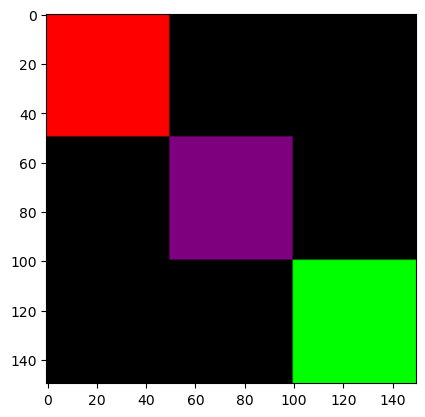

In [12]:
%matplotlib inline  
image_example()

The following functions are used to calculate the probability of a cell dying at a certain time step after being infected.

In [13]:


def normpdf(x, mean, sd):
    """
    Return the value of the normal distribution 
    with the specified mean and standard deviation (sd) at
    position x.
    You do not have to understand how this function works exactly. 
    """
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

def pdeath(x, mean, sd):
    start = x-0.5
    end = x+0.5
    step =0.01    
    integral = 0.0
    while start<=end:
        integral += step * (normpdf(start,mean,sd) + normpdf(start+step,mean,sd)) / 2
        start += step            
    return integral    
    


Some constants we will use later in the simulation: 

In [14]:
recovery_time = 4 # recovery time in time-steps
virality = 0.2    # probability that a neighbor cell is infected in 
                  # each time step                                                 

This is where your code starts.

In [ ]:
class Cell(object):

    def __init__(self,x, y):
        self.x = x
        self.y = y 
        self.state = "S" # can be "S" (susceptible), "R" (resistant = dead), or 
                         # "I" (infected)
        self.time = 0
        
    def infect(self): # Step 2.1
        # infect cell, reset time to 0
        self.state = "I"
        self.time = 0


    def process(self, adjacent_cells): # Step 2.3
        """
        Process this cell for one time step.
        Only cells in state 'I' do anything.
        - If time < 1: increment time, return immediately
        - If time >= 1: try infecting neighbors
        """
        # if not infected, nothing to do except maybe increment time later
        if self.state != "I":
            return
        
        # If newly infected (time == 0), do not infect neighbors yet
        if self.time < 1:
            self.time += 1
            return
        
        # If infected for at least 1 step: try infecting neighbors
        import random
        global virality   # probability a neighbor gets infected

        for neighbor in adjacent_cells:
            if neighbor.state == "S":
                # random chance to infect
                if random.random() <= virality:
                    neighbor.infect()
        
        # After attempting infections, increase infection time
        self.time += 1

In [ ]:
class Map(object):
    
    def __init__(self):
        self.height = 150
        self.width = 150           
        self.cells = {}

    def add_cell(self, cell): # Step 1.1 
        cell = self.cels[(cell.x,cell.y)] # store cells in dictionary by their coordinates
        
    def display(self): # Step 1.3
        img = np.zeros((self.height, self.width, 3))
        red, green, blue = range(3)

        #plt.imshow(image)  # display the map
        for (x, y), cell in self.cells.items():
            if cell.state == "S":         # susceptible -> green
                img[x, y, green] = 1.0
            elif cell.state == "I":       # infected -> red
                img[x, y, red] = 1.0
            elif cell.state == "R":       # resistant (dead) -> gray
                img[x, y, :] = 0.5
        plt.imshow(img)
    
    def adjacent_cells(self, x,y): # Step 2.2
        """
        Return a list of Cell objects adjacent to (x, y).
        Adjacent = N, E, S, W (no diagonals)
        """
        neighbors = []
        directions = [
            (0, -1),   # north
            (1, 0),    # east
            (0, 1),    # south
            (-1, 0)    # west
        ]

        for dx, dy in directions:
            nx = x + dx
            ny = y + dy
            # boundary check
            if 0 <= nx < self.width and 0 <= ny < self.height:
                if (nx, ny) in self.cells:
                    neighbors.append(self.cells[(nx, ny)])

        return neighbors


    def time_step(self): # Step 2.4
        """
        Process the map for one discrete time step.
        - For every cell: call cell.process(adjacent_cells)
        - Then display the updated map
        """
        # First gather a list of all cells (so adjacency isn’t affected mid-loop)
        all_cells = list(self.cells.values())

        for cell in all_cells:
            adj = self.adjacent_cells(cell.x, cell.y)
            cell.process(adj)

        # After updating all cells, display the map
        self.display()


In [17]:
def read_map(filename):
    
    m = Map()
    
    # ... Write this function, Step 1.2
    # open filename and reads through it one line at a time
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
        x_str, y_str = line.split(",")
        # store the coordinates in variables x and y
        x = int(x_str)
        y = int(y_str)

        # creates a Cell object with x and y coordinates
        cell = Cell(x,y)
        m.add_cell(cell)
    
    return m

In [18]:
m = read_map("nyc_map.csv")

AttributeError: 'Map' object has no attribute 'cels'

In [ ]:
m.display()